# Integrating the moment equations - mRNA

(c) 2017 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT)

---

In [1]:
import pickle
import dill # Library that we will use to export lambdify functions
# Our numerical workhorses
import numpy as np
# To compute symbolic expressions
import sympy
sympy.init_printing(use_unicode=True, use_latex=True) # print outputs in LaTeX

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

tmpdir = '../../tmp/'

### $\LaTeX$ macros
$\newcommand{kpon}{k^{(p)}_{\text{on}}}$
$\newcommand{kpoff}{k^{(p)}_{\text{off}}}$
$\newcommand{kron}{k^{(r)}_{\text{on}}}$
$\newcommand{kroff}{k^{(r)}_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{mm}{\left\langle m \right\rangle}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$

# Two-state promoter (mRNA)

In this section we will try to solve the differential equations for the mRNA distribution moments for the two-state unregulated promoter.

Up to this stage we wrote the chemical master equation in matrix notation and did some tricks when it came to compute the $n^{\text{th}}$ moment. Now we will use the equations we obtained for the time derivative of the mRNA distribution moments and try to solve them.

Let's first define the `sympy` variables that we will need for the two- and three-state promoter.

Note: It is important to specify the variables we are defining are real positive nubers. Otherwise `sympy` would be unable to solve the system.

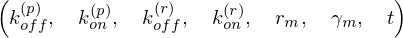

In [2]:
# Define rate constant variables
kp_off, kp_on = sympy.symbols('{k_{off}^{(p)}} {k_{on}^{(p)}}', 
                              real=True, positive=True)
kr_off, kr_on = sympy.symbols('{k_{off}^{(r)}} {k_{on}^{(r)}}', 
                              real=True, positive=True)

# Define degradation rate and production rate
rm, gm = sympy.symbols('r_m gamma_m', real=True, positive=True)

# Define the time variable
t = sympy.symbols('t', real=True, positive=True)

kp_off, kp_on, kr_off, kr_on, rm, gm, t

Let's now define a function that generates a `sympy` variable of the form $\left\langle x^n \right\rangle$ to easily define the variables to save the moments.

In [3]:
def moment_sympy(var, moment, function=None):
    '''
    Shortcut to generate variables of the form <var**n> in sympy to facilitate the
    definition of the moment variables
    Parameters
    ----------
    var : string.
        variable name string that should be put inside the <> parenthesis.
    moment : int.
        exponent of the moment to be defined.
    function : variable
        if given the returned variables are functions rather than symbols
    '''
    if function == None:
        if moment == None:
            return sympy.Symbol('{\\langle ' + var + '\\rangle}',
                               real=True, positive=True)
        else:
            return sympy.Symbol('{\\langle ' + var + '^{:d}'.format(moment) +\
                                '\\rangle}', real=True, positive=True)
    
    else:
        if moment == None:
            return sympy.Function('\\langle ' + var + '\\rangle',
                                 real=True, positive=True)(function)
        else:
            return sympy.Function('\\langle ' + var + '^{:d}'.format(moment) +\
                                '\\rangle', real=True, positive=True)(function)

Now let's define the moment variables for the unregulated promoter.

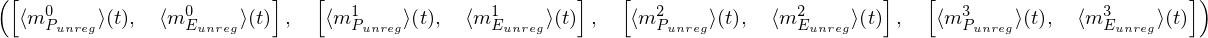

In [4]:
# Define the string for the states
m_unreg = ['m_{P_{unreg}}', 'm_{E_{unreg}}']

# Define the zeroth moments
m0_unreg = [moment_sympy(x, 0, t) for x in m_unreg]
# Define the first moments
m1_unreg = [moment_sympy(x, 1, t) for x in m_unreg]
# Define the second moments
m2_unreg = [moment_sympy(x, 2, t) for x in m_unreg]
# Define the second moments
m3_unreg = [moment_sympy(x, 3, t) for x in m_unreg]

m0_unreg, m1_unreg, m2_unreg, m3_unreg

Let's now define the global moments.

In [6]:
# define "global" moments
mm0_unreg = moment_sympy('\mathbf{m}_u', 0, t)
mm1_unreg = moment_sympy('\mathbf{m}_u', None, t)
mm2_unreg = moment_sympy('\mathbf{m}_u', 2, t)
mm3_unreg = moment_sympy('\mathbf{m}_u', 3, t)

mm0_unreg, mm1_unreg, mm2_unreg, mm3_unreg

Now we will define the state transition matrix $\mathbf{K}^u$, the mRNA production matrix $\mathbf{R}^u_m$ and the mRNA degradation matrix $\mathbf{\Gamma}^u_m$.

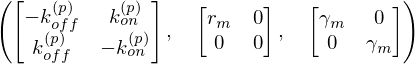

In [7]:
# Define the rate constant matrix
Kmat_unreg = sympy.Matrix([[-kp_off, kp_on], 
                           [kp_off, -kp_on]])
# Define the production matrix
Rmat_unreg = sympy.Matrix([[rm, 0], 
                           [0, 0]])
# Define the degradation matrix
Gmat_unreg = sympy.Matrix([[gm, 0],
                           [0, gm]])

Kmat_unreg, Rmat_unreg, Gmat_unreg

### Zeroth moment two-state promoter
In order to solve for the two-state promoter we have two equations to use
$$
\bb{1} = \mathbf{u} \cdot \left\langle \mathbf{m}^0 \right\rangle,
$$
where $u = (1, 1)$ and $\left\langle \mathbf{m}^0 \right\rangle$ is the vector containing all the states, and
$$
{d \over dt} \ee{\bb{m}^0} = \mathbf{K}^u_m \left\langle \mathbf{m}^0 \right\rangle.
$$

We will use the linear algebra solver where we write an extended matrix with the last column being the right hand side of these equations.

Let's now define this system.

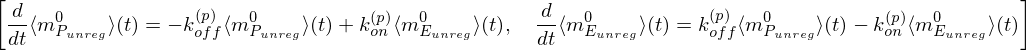

In [8]:
dm0dt_unreg = sympy.Matrix([m.diff() for m in m0_unreg])
dm0dt_rhs = Kmat_unreg * sympy.Matrix(m0_unreg)

sys = [sympy.Eq(dm0dt_unreg[i], dm0dt_rhs[i]) for i in range(2)]
sys

Let's now solve the system.

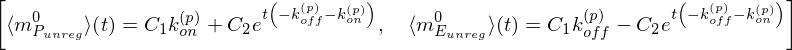

In [9]:
# Solving the system using dsolve
dm0dt_sol = sympy.dsolve(sys)

# Split left hand side and right hand side
dm0dt_rhs = [x.rhs for x in dm0dt_sol]
dm0dt_lhs = [x.lhs for x in dm0dt_sol]

dm0dt_sol

Now let's use the initial conditions to find the value of the constants. For the initial conditions we will simply call $\ee{m_{X_{unreg}}}(0) = \ee{m_{X_{0}}}$

In [10]:
# Define the string for the states
m_unreg = ['m_{P_{0}}', 'm_{E_{0}}']
m0_unreg_init = [moment_sympy(x, 0) for x in m_unreg] 
m0_unreg_init

Let's substitute these initial conditions and equate them to the right hand side of the solution evaluated at $t=0$

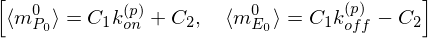

In [11]:
# Building system evaluated at the inital condition
dm0dt_zero = [sympy.Eq(m0_unreg_init[x], 
                        dm0dt_rhs[x].subs(t, 0)) for x in range(2)]
dm0dt_zero

Finally, let's solve for the constants.

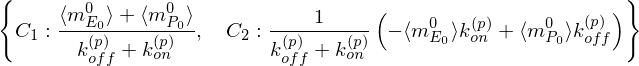

In [12]:
constants = sympy.solve(dm0dt_zero, sympy.symbols('C1 C2'))
constants

We can use the fact that the sum of initial conditions should add up to one.

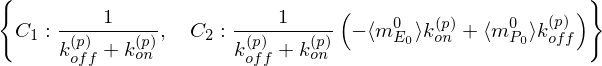

In [13]:
# Substitute the sum of the initial conditions
constants[sympy.Symbol('C1')] = constants[sympy.Symbol('C1')].\
                                subs(sum(m0_unreg_init), 1)
constants

And finally substitute these constants into the solution.

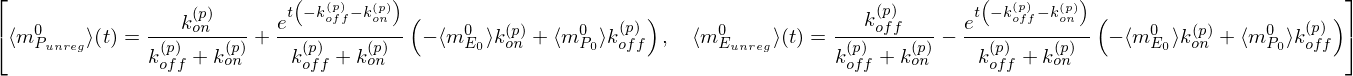

In [14]:
# substitute constants
dm0dt_sol = [x.subs(constants) for x in dm0dt_sol]

# Split left hand side and right hand side
dm0dt_rhs = [x.rhs for x in dm0dt_sol]
dm0dt_lhs = [x.lhs for x in dm0dt_sol]
# save solution as dictionary (useful for later one substitutions)
dm0dt_dict = dict(zip(dm0dt_lhs, dm0dt_rhs))

dm0dt_sol

To check that this solution makes sense let's take the limit then $t \rightarrow \infty$ to see if we recover the steady state solution we derived before.

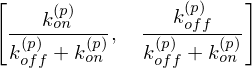

In [118]:
# Taking the limit when time goes to infinity
[sympy.limit(x.rhs, t, 'oo') for x in dm0dt_sol]

---

### First moment two-state promoter

Now that we have the zeroth moment that indicates the probability of being on either state let's now compute the first moment. For this we have the matrix equation
$$
{d \over dt}\ee{\bb{m}^1} = 
\left( \mathbf{K}^u_m - \mathbf{\Gamma}^u_m  \right)\ee{\bb{m}^1}
             + \mathbf{R}^u_m \left\langle \mathbf{m}^0 \right\rangle.
$$

Let's define this system.

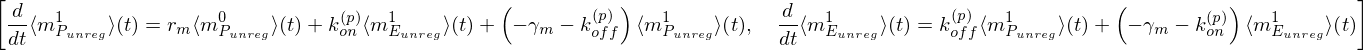

In [97]:
dm1dt_unreg = sympy.Matrix([m.diff() for m in m1_unreg])
dm1dt_rhs = (Kmat_unreg - Gmat_unreg)* sympy.Matrix(m1_unreg) +\
            Rmat_unreg * sympy.Matrix(m0_unreg)

sys = [sympy.Eq(dm1dt_unreg[i], dm1dt_rhs[i]) for i in range(2)]
sys

Let's now substitute the solution for the zeroth moment.

Note: This could have been done in a single step, but it is good to see every step when troubleshooting.

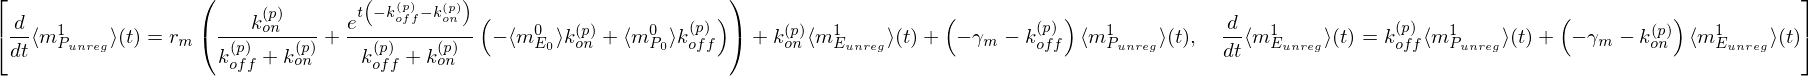

In [98]:
sys = [x.subs(dm0dt_dict) for x in sys]
sys

Now let's try to solve the system

In [17]:
# Solving the system using dsolve
dm1dt_sol = sympy.dsolve(sys)

# Split left hand side and right hand side
dm1dt_rhs = [x.rhs for x in dm1dt_sol]
dm1dt_lhs = [x.lhs for x in dm1dt_sol]

dm1dt_sol

NotImplementedError: 

Sympy cannot apparently solve this system. But we can try to define a differential equation for the "global" moment $\ee{\bb{m}^1}$ defined as the sum of the first moments for all promoter states.

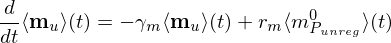

In [99]:
# Sum both differential equations and ractor terms
dmm1dt_rhs = sum(dm1dt_rhs).collect(m1_unreg[0]).\
                            collect(m1_unreg[1]).\
                            collect(gm).\
                            subs(sum(m1_unreg), mm1_unreg)

# Print differential equation for global moment
sympy.Eq(mm1_unreg.diff(), dmm1dt_rhs)

Let's now attempt to solve the system.

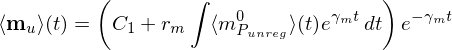

In [100]:
# Solve equation for global first moment
dmm1dt_sol = sympy.dsolve(sympy.Eq(mm1_unreg.diff(), dmm1dt_rhs))
dmm1dt_sol

Since we know the solution for the zeroth moment, let's try to substitute it.

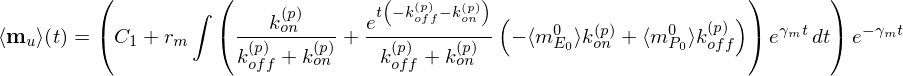

In [101]:
dmm1dt_sol = dmm1dt_sol.subs(dm0dt_dict)
dmm1dt_sol

The symbolic integral must be solvable. Let's try to expand the terms to see each of the individual terms inside the integral.

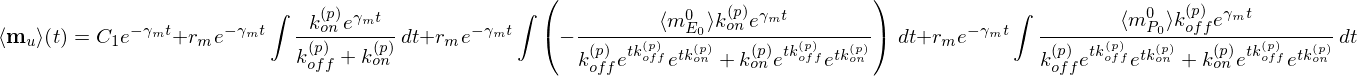

In [102]:
dmm1dt_sol = dmm1dt_sol.expand()
dmm1dt_sol

To perform each of these integrals we will split the left hand side of the equation into the individual components and solve each of them individually.

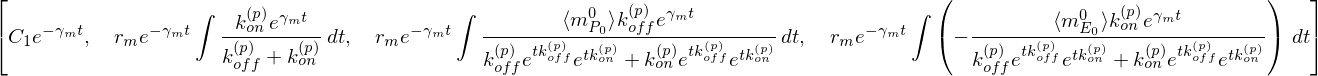

In [103]:
# Split terms and convert them to list in order to modify them.
dmm1dt_sol_rhs = list(dmm1dt_sol.rhs.args)
dmm1dt_sol_rhs

The first integral term is easily solved since the integral is pretty simple.

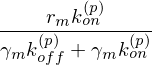

In [104]:
dmm1dt_sol_rhs[1] = dmm1dt_sol_rhs[1].doit()
dmm1dt_sol_rhs[1]

For the second integral we have a case in which `sympy` presents two possible solutions.

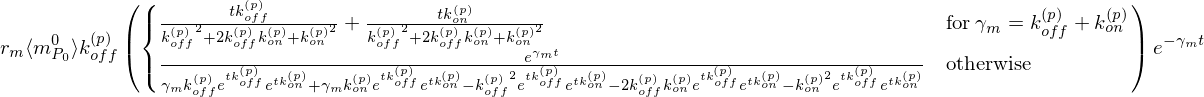

In [106]:
integral = dmm1dt_sol_rhs[2].doit()
integral

`Sympy` gives one solution for the case when $\gm = \kpon + \kpoff$ and other cases. Since this is a condition that we definitely do not want to impose in our solution we need to choose the general solution.

Given that I do not find a way to tell `sympy` that the equality is not satisfied we will have to 
1. Split the terms in the expression.
2. Choose the general solution.
3. Substitute back and compile again.

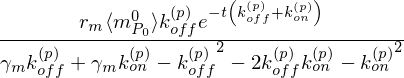

In [107]:
# split integral into its components.
integral_args = list(integral.args)

# Let's now select the integral part and split it into its components
piecewise_args = integral_args[-2].args

# Now let's select the general solution and substitute it back into the
# split integral terms
integral_args[-2] = piecewise_args[1][0]

# Let's collect the terms and compute the integral
dmm1dt_sol_rhs[2] = np.prod(integral_args).simplify()
dmm1dt_sol_rhs[2]

Let's follow the same procedure for the last integral in the solution.

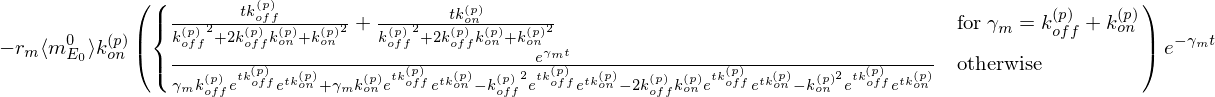

In [108]:
integral = dmm1dt_sol_rhs[3].doit()
integral

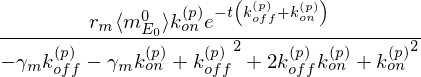

In [109]:
# split integral into its components.
integral_args = list(integral.args)

# Let's now select the integral part and split it into its components
piecewise_args = integral_args[-2].args

# Now let's select the general solution and substitute it back into the
# split integral terms
integral_args[-2] = piecewise_args[1][0]

# Let's collect the terms and compute the integral
dmm1dt_sol_rhs[3] = np.prod(integral_args).simplify()
dmm1dt_sol_rhs[3]

Having done this we can put the solution for ${d \over dt}\ee{\bb{m}^1}$ together.

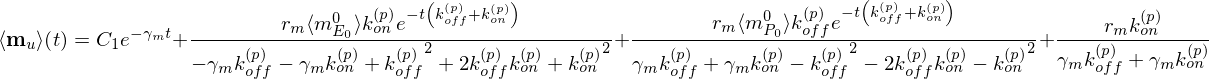

In [110]:
dmm1dt_sol = sympy.Eq(dmm1dt_sol.lhs, sum(dmm1dt_sol_rhs))
dmm1dt_sol

And just as with the zeroth moment solution we will use initial conditions of the form $\ee{\bb{m}}(0) = \ee{\bb{m}_0}$

In [111]:
# Define the string for the states
m1_unreg_init = moment_sympy('\mathbf{m}_0', 1)
m1_unreg_init

Let's substitute $t=0$ in the solution.

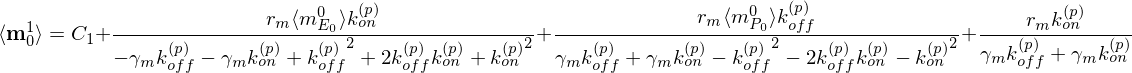

In [112]:
dmm1dt_zero = sympy.Eq(m1_unreg_init, dmm1dt_sol.rhs.subs(t, 0))
dmm1dt_zero

And solve for the constant.

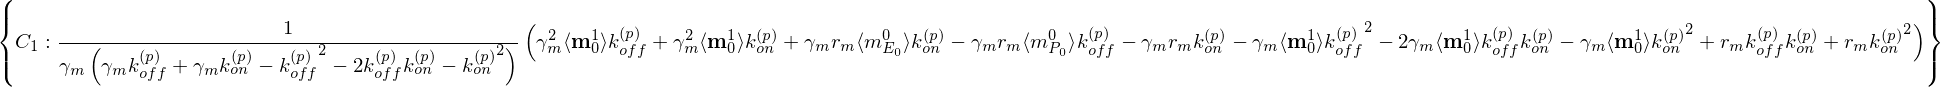

In [113]:
constant = sympy.solve(dmm1dt_zero, sympy.Symbol('C1'), dict=True)[0]
constant

Now we can substitute this result into the solution.

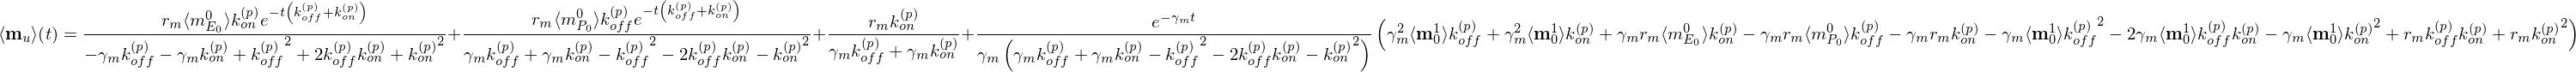

In [114]:
# substitute constants
dmm1dt_sol = dmm1dt_sol.subs(constant)

# Split left hand side and right hand side
dmm1dt_rhs = dmm1dt_sol.rhs 
dmm1dt_lhs = dmm1dt_sol.lhs

# save solution as dictionary (useful for later one substitutions)
dmm1dt_dict = {dmm1dt_rhs, dmm1dt_lhs}

dmm1dt_sol

To check that this solution makes sense let's take the limit then $t \rightarrow \infty$ to see if we recover the steady state solution we derived before.

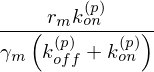

In [119]:
# Taking the limit when time goes to infinity
sympy.limit(dmm1dt_sol.rhs, t, 'oo').collect(gm)